# モンテカルロサンプリングと相転移点の推定

OpenJijはSimulated annealing (SA)を実行します。温度を一定に保てば、その温度でのカノニカル分布

$$
p(\{\sigma\}) = \frac{\exp(-\beta E(\{\sigma\}))}{Z}, \ Z = \sum_{\{\sigma\}}\exp(-\beta E(\{\sigma\}))
$$

からスピン配列をサンプルすることが可能です。

以下では全結合の強磁性イジングモデル

$$
E(\{\sigma\}) = \frac{J}{N} \sum_{i<j} \sigma_i \sigma_j \ (J<0)
$$

を取り扱います。エネルギーをシステムサイズ$N$で割ることで、ハミルトニアンを$N$と同じ程度の大きさに規格化しています。またここでは$J = -1$です。

In [2]:
# ライブラリのインポート
import openjij as oj
import numpy as np
import matplotlib.pyplot as plt

# サンプラーの設定
sampler = oj.SASampler()

# 全結合問題の定義
def fully_connected(n):
    h, J = {}, {}
    for i in range(n-1):
        for j in range(i+1, n):
            J[i, j] = -1/n
    return h, J

# h, Jの設定
h, J = fully_connected(n=500)

各温度での磁化

$$
m = \frac{1}{N} \sum_i \sigma_i
$$

を計算してみましょう。この値が1に近いほど、スピンが揃っている状態(強磁性)を表します。逆にこの値が0に近いほど、スピンがバラバラな状態(常磁性)を表します。  
温度を一定にしてOpenJijで計算を行うと、温度が1.0付近で磁化の値が0に近づいていくことがわかります。これは温度が上昇するとスピンがバラバラになりやすいためです。

In [3]:
# 温度のリストの作成
temp_list = np.linspace(0.01, 2, 30)

# 磁化とその分散を計算
mag, mag_std = [], []
for temp in temp_list:
    beta = 1.0/temp
    schedule = [[beta, 100]]
    response = sampler.sample_ising(h, J, schedule=schedule)
    mag_list = [np.abs(np.mean(state)) for state in response.states]
    mag_std.append(np.std(mag_list))
    mag.append(np.mean(mag_list))

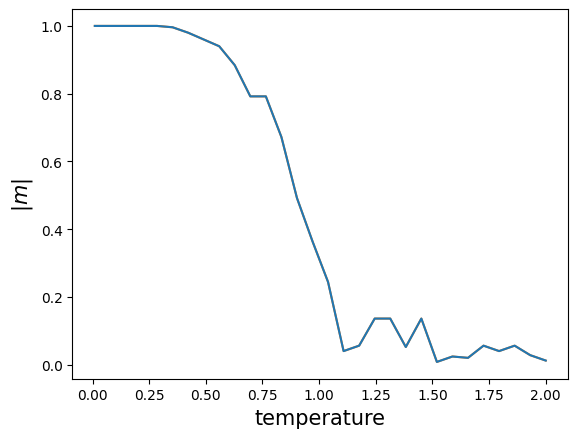

In [4]:
# 結果の可視化
plt.errorbar(temp_list, mag, yerr=mag_std)
plt.plot(temp_list, mag)
plt.xlabel('temperature', fontsize=15)
plt.ylabel(r'$|m|$', fontsize=15)
plt.show()

ある温度を境に値が大きく変わる、このような現象を**相転移**と呼びます。今回の模型では(システムサイズを無限大に近づけると)温度が1.0の時に相転移が起こることが、理論的に証明されています。  
ただし、実際のモデルではどの程度の温度で相転移が起きるかを理論的に計算できない場合が多々あります。そのため、モンテカルロシミュレーションを用いて相転移に関する性質を数値的に研究する手法が多く取られています。

## Binder cumulant

それでは、仮に相転移する温度を事前に知らなかったとして、数値計算からできるだけ正確に相転移する温度を求めてみましょう。上図を見ると、確かに磁化は温度が上がるにつれて0に近づいています。しかしどの温度が相転移点なのかまでははっきりしていません。これは、相転移現象は理論的にはサイズが無限大のシステムで起こる現象ですが、シミュレーションでは有限のサイズしか扱えないことにより理論との誤差が出てくることに起因します。これを**有限サイズ効果**と呼びます。  
サイズが無限大のシステムの解析を数値的に行うことは、一見無理なことのように思われます。しかし、統計力学の数値計算分野に置いて、有限のシステムサイズから無限大のシステムサイズの情報を得る手法が開発されてきました。  
そのうちの一つが**Binder cumulant**という量を用いる方法です。

$$U_4 \equiv \frac{1}{2}\left( 3- \frac{\langle m^4\rangle}{\langle m^2\rangle^2} \right)$$

In [5]:
# U_4の計算
def u_4(states):
    m = np.array([np.mean(state) for state in states])
    return 0.5 * (3-np.mean(m**4)/(np.mean(m**2)**2))

詳細は統計力学の教科書に譲りますが、この量は磁化が1に近づく強磁性では1に近づき、磁化が0に近づく常磁性では0になることが示せます。さらに相転移点ではシステムサイズに依存しない値を取ることが知られています。そのため、いくつかのシステムサイズで上述のような数値実験を行い、$U_4$のグラフが1点で交わる箇所が相転移点であると言えます。以下で実際の計算を行いましょう。

In [ ]:
# 系のサイズをリストで定義
n_list = [40, 80, 120, 160]
# 温度をリストで定義
temp_list = np.linspace(0.5, 1.5, 30)

# サンプラーを設定
sampler = oj.SASampler()

u4_list_n = []
for n in n_list:
    # インスタンス作成
    h, J = fully_connected(n)
    u4_temp = []
    for temp in temp_list:
        beta = 1.0/temp
        schedule = [[beta, 100 if temp < 0.9 else 300]]
        response = sampler.sample_ising(h, J, 
                                        schedule=schedule, reinitialize_state=False,
                                        num_reads=100 if temp < 0.9 else 1000
                                       )
        u4_temp.append(u_4(response.states))
    u4_list_n.append(u4_temp)

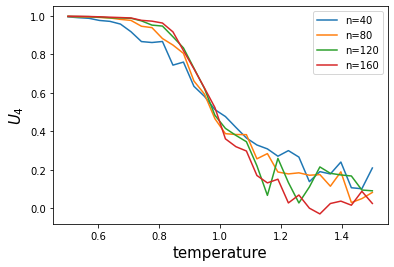

In [ ]:
# 可視化
for n,u4_beta in zip(n_list,u4_list_n):
    plt.plot(temp_list, np.array(u4_beta), label='n={}'.format(n))

plt.legend()
plt.ylabel('$U_4$', fontsize=15)
plt.xlabel('temperature', fontsize=15)
plt.show()

統計が十分でないため、データにばらつきがあります。しかしおおよそ相転移点である温度が1付近で4つのシステムサイズのデータが1点で交わっていることとがわかります。  
Binder cumulant による相転移点の推定は数値解析の最前線でよく用いられる手法です。

> 当然ですが、学術的な研究では十分な統計を取ることはもちろん、誤差評価(エラーバーの計算)なども真面目に行う必要があるでしょう。今回の計算は概要の説明だけに留めてあるため、正確な誤差評価等は省略しています。

## まとめ

アニーリングを用いてMonteCarlo samplingを行う方法をご紹介しました。それを応用して統計物理学における相転移の計算例を示しました。ここからもわかるように、OpenJijはアイデア次第で様々な応用が可能です。